<a href="https://colab.research.google.com/github/dsaichand3/Competitions/blob/master/News_Categories_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np 
import pandas as pd
import string
from collections import Counter
import seaborn as sns
sns.set(rc={'figure.figsize':(12,9)})
import matplotlib.pyplot as plot

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, Dropout, Activation, BatchNormalization, CuDNNLSTM, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn import metrics
import re

!pip install num2words
from num2words import num2words


Using TensorFlow backend.


In [0]:
SEQUENCE_LENGTH = 125
EMBEDDING_DIM = 300

In [0]:
train = pd.read_excel('Data_Train.xlsx')

In [4]:
train.head(10)

,STORY,SECTION
0,But the most painful was the huge reversal in ...,3
1,How formidable is the opposition alliance amon...,0
2,Most Asian currencies were trading lower today...,3
3,"If you want to answer any question, click on ‘...",1
4,"In global markets, gold prices edged up today ...",3
5,BEIJING: Chinese tech giant Huawei has announc...,1
6,Mumbai: India Inc's external commercial borrow...,3
7,"On Wednesday, Federal Reserve Chairman Jerome ...",3
8,What more can you give to the audience? I have...,2
9,"com, Arbaaz Khan spoke about getting back to D...",2


In [0]:
contraction_mapping = {'What”s':'what is', 'What"s':'what is',"its":"it is","What's":"what is", "'ll": "will", "n't": "not", "'re":"are", "ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "'they're":"they are","they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have" }
contractions = set(contraction_mapping)

def pre_processing(sentence):
    
    out = sentence.replace('\n', ' ').replace('\t', ' ').replace('\xa0',' ')\
    .replace("？", "?").replace("…", " ").replace("é", "e")
    
    for punct in "./-'‘_“”#":
        out = out.replace(punct, ' ')
    for punct in '&':
        out = out.replace(punct, f'{punct} ')
    out = out.translate(str.maketrans('', '', string.punctuation))
    #out = out.translate(str.maketrans('', '', string.digits))
    out = out.lower()

    new_sentence = []
    for word in out:
        if word =='—':
            word=" "
        new_sentence.append(word)
    return "".join(new_sentence)

#Removing the left right and in between empty spaces.
def left_right_spaces(sentence):
    new_sentence = []
    for word in sentence.split(' '):
        if word!='':
            new_sentence.append(word)
    return " ".join(new_sentence)
            
#These words are decided after exploring dataset
stop_words = ["the","a","is","to","be","are","what","and","of","in","it","on","for","that","with","has",
              "as","will","from","by","have","an","at","this","been","their","there","or","also","not","i",
              "which","his","but","had","was","said"]

def own_stop_words(sentence, stop_words = stop_words):
    new_sentence = []
    for word in sentence.split(' '):
        if word not in stop_words:
            new_sentence.append(word)
    return " ".join(new_sentence)

#Contractions like "aren't" are replaced with "are not"
def known_contractions(sentence):
    sentence = sentence.replace("’", "'").replace("`", "'").replace("´", "'")
    new_sentence = []
    for word in sentence.split(' '):
        if word in contractions:
            new_sentence.append(contraction_mapping[word])
        else:
            new_sentence.append(word)
    return " ".join(new_sentence)

#Words like india's economy, america's economy are replaced with just india economy, america economy etc. 
def smart_words(sentence):
    new_sentence = []
    for word in sentence.split(' '):
        if word=="'s":
            word=""
        new_sentence.append(re.sub('[\w]+\s*[\’\´\'\”\’\"\”]\s*[s]',word[:-2], word))            
    return " ".join(new_sentence)

#Some common country names are replaced with a common word to reduce vocabulary.
america_names = ["USA","U.S","U.S.A","U.S.","usa","US","U.S,","U.S.A,","U.S.","usa,","US,","US?","U.S?","U.S.A?","U.S.?","usa?","U.S.A?"]
uk = ["U.K","U.K?","U.K,","U.K."]
america_names = set(america_names)
uk = set(uk)
def countries(sentence):
    new_sentence = []
    for word in sentence.split(' '):
        if word in america_names:
            new_sentence.append('america')
        elif word in uk:
            new_sentence.append('united kingdom')
        else:
            new_sentence.append(word)
    return " ".join(new_sentence)


#Symbols are replaced with the textual information to retain important information.
def replace_symbols(sentence):
    sentence = sentence.replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
    .replace("€", " euro ").replace("?",'').replace("INR"," rupee ").replace("Rs."," rupee ").replace("Rs"," rupee ")
    
    return sentence

#Numbers like 100k is replaced with 100 thousand, 21yrs is replaced with 21 years, 1990's with 1990 and so on.
def preprocessing_numbers(row):
    row = re.sub('(?<=[0-9])\,(?=[0-9])', "", row) #removing ,(comma) between the numbers
    new_sentence = []
    for word in row.split(' '):
        match = re.match(r"(^[0-9]+)(\'*\’*k{1}$)", word)
        if match:
            items = match.groups()
            new_sentence.append(items[0])
            new_sentence.append('thousand')
        else:
            new_sentence.append(word)
            
    sentence = " ".join(new_sentence)
    new_sentence = []
    for word in sentence.split(' '):
        match = re.match(r"(^[0-9]+)(\'*\’*y{1}r?s?$)", word)
        if match:
            items = match.groups()
            new_sentence.append(items[0])
            new_sentence.append('year')
        else:
            new_sentence.append(word)

    sentence = " ".join(new_sentence)
    new_sentence = []
    for word in sentence.split(' '):
        match = re.match(r"(^[0-9]+)(\'*\’*s{1}$)", word)
        if match:
            items = match.groups()
            new_sentence.append(items[0])
        else:
            new_sentence.append(word)

    sentence = " ".join(new_sentence)
    new_sentence = []
    for word in sentence.split(' '):
        match = re.match(r"([0-9]+)([a-zA-Z]+)", word)
        if match:
            items = match.groups()
            new_sentence.append(items[0])
            new_sentence.append(items[1])
        else:
            new_sentence.append(word)
    return " ".join(new_sentence)

#Numbers are replaced with textual information to retain the value of sentence.
def num_to_text(sentence):
    sentence = sentence.replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
    .replace("€", " euro").replace("?",'').replace("INR"," rupee ").replace("Rs."," rupee ")
    new_sentence = []
    for word in sentence.split(' '):
        try:
            word = int(word)
            if word<=1000 and word>=0:
                text = num2words(word)
                new_sentence.append(text)
            else:
                new_sentence.append(str(word))
        except:
            new_sentence.append(str(word))
    return " ".join(new_sentence)

def handling_decimal_numbers(sentence):
    new_sentence = []
    for word in sentence.split(' '):
        match = re.match(r"([0-9]+)(\.)([0-9]+)", word)
        if match:
            items = match.groups()
            #new_sentence.append(items[0])
            #new_sentence.append('point')
            #new_sentence.append(items[2])
            new_sentence.append("")
        else:
            new_sentence.append(word)
    return " ".join(new_sentence)

In [0]:
train['STORY'] = train['STORY'].apply(countries)
train['STORY'] = train['STORY'].apply(countries)

train['STORY'] = train['STORY'].apply(known_contractions)
train['STORY'] = train['STORY'].apply(known_contractions)

train['STORY'] = train['STORY'].apply(smart_words)
train['STORY'] = train['STORY'].apply(smart_words)

train['STORY'] = train['STORY'].apply(replace_symbols)
train['STORY'] = train['STORY'].apply(replace_symbols)

train['STORY'] = train['STORY'].apply(preprocessing_numbers)
train['STORY'] = train['STORY'].apply(preprocessing_numbers)

train['STORY'] = train['STORY'].apply(num_to_text)
train['STORY'] = train['STORY'].apply(num_to_text)

train['STORY'] = train['STORY'].apply(handling_decimal_numbers)
train['STORY'] = train['STORY'].apply(handling_decimal_numbers)

train['STORY'] = train['STORY'].apply(pre_processing)
train['STORY'] = train['STORY'].apply(pre_processing)

train['STORY'] = train['STORY'].apply(own_stop_words)
train['STORY'] = train['STORY'].apply(own_stop_words)

train['STORY'] = train['STORY'].apply(left_right_spaces)
train['STORY'] = train['STORY'].apply(left_right_spaces)

train['STORY'] = train['STORY'].apply(preprocessing_numbers)
train['STORY'] = train['STORY'].apply(preprocessing_numbers)

train['STORY'] = train['STORY'].apply(num_to_text)
train['STORY'] = train['STORY'].apply(num_to_text)

In [0]:
words_1 = []
for doc in train['STORY']:
    for word in doc.split(' '):
        if word!='':
            words_1.append(word)

words_1_count = Counter(words_1)

total_words = words_1_count

In [8]:
!wget http://nlp.stanford.edu/data/glove.840B.300d.zip

!unzip glove*.zip

!rm glove.840B.300d.zip

total_words = set(total_words)
print('Indexing word vectors.')

embeddings_index = {}
f = open('glove.840B.300d.txt', encoding='utf-8')

for line in f:
    values = line.split()
    word = values[0]
    if word in total_words:
        coefs = np.asarray(values[-300:], dtype='float32')
        embeddings_index[word] = coefs
    if len(embeddings_index)==len(total_words):
        print("done")
f.close()
print('Found %s word vectors.' % len(embeddings_index))

#!rm glove.840B.300d.txt
#del total_words

--2019-08-01 05:26:24--  http://nlp.stanford.edu/data/glove.840B.300d.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.840B.300d.zip [following]
--2019-08-01 05:26:24--  https://nlp.stanford.edu/data/glove.840B.300d.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.840B.300d.zip [following]
--2019-08-01 05:26:24--  http://downloads.cs.stanford.edu/nlp/data/glove.840B.300d.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2176768927 (2.0G) [application/zip

In [9]:
print("Total number of words (vocabulary size): ", len(total_words))
print("Embeddings found for the words: ", len(embeddings_index))
print("Percentage of words having embeddings: ", (len(embeddings_index)/len(total_words))*100)
print("Percentage of words not having embeddings: ", 100 - (len(embeddings_index)/len(total_words))*100)

Total number of words (vocabulary size):  32640
Embeddings found for the words:  26957
Percentage of words having embeddings:  82.58884803921569
Percentage of words not having embeddings:  17.41115196078431


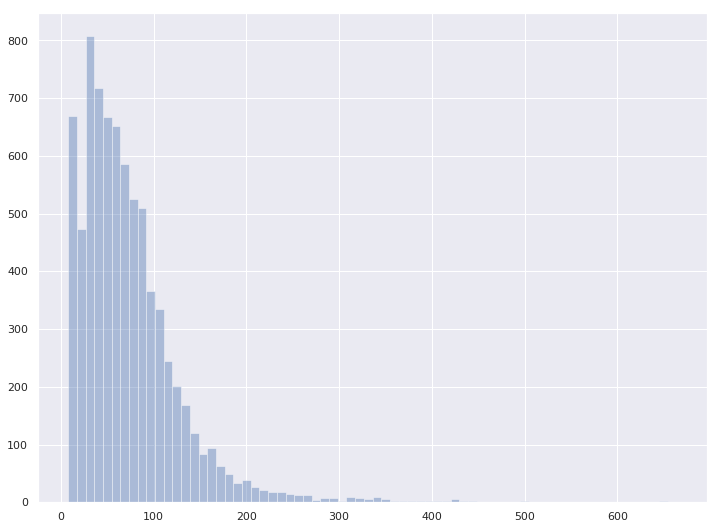

In [10]:
values = []
for row in train['STORY']:
    values.append(len(row.split(' ')))
values = np.array(values)

sns.distplot(values, kde = False, bins = 70)

In [0]:
use_words = []
for word in total_words:
    if word not in embeddings_index:
        use_words.append(word)

In [0]:
train = train.sample(frac=1)
target = train['SECTION']
train.drop(['SECTION'], axis = 1, inplace = True)

In [0]:
X_train, X_val, y_train, y_val = train_test_split(train, target, stratify = target, test_size=0.2)

In [0]:
def embeddings(sentence):
    new_sentence = []
    for word in sentence.split(' '):
        if word in embeddings_index:
            new_sentence.append(embeddings_index[word])
        else:
            new_sentence.append(np.zeros(EMBEDDING_DIM))
    return new_sentence

In [69]:
sequence_1_input = Input(shape = (SEQUENCE_LENGTH, EMBEDDING_DIM))
x1 = Bidirectional(CuDNNLSTM(256, return_sequences = True))(sequence_1_input)
x1 = Dropout(0.4)(x1)
x1 = Bidirectional(CuDNNLSTM(256))(x1)

merged = BatchNormalization()(x1)
merged = Dense(200, activation='relu')(merged)
merged = Dropout(0.4)(merged)

merged = BatchNormalization()(merged)
merged = Dense(200, activation='relu')(merged)
merged = Dropout(0.4)(merged)

merged = BatchNormalization()(merged)
merged = Dense(100, activation='relu')(merged)
merged = Dropout(0.4)(merged)

preds = Dense(4, activation='softmax')(merged)

model = Model(inputs= sequence_1_input, outputs = preds)

model.compile(loss='sparse_categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 125, 300)]        0         
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 125, 512)          1142784   
_________________________________________________________________
dropout_16 (Dropout)         (None, 125, 512)          0         
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 512)               1576960   
_________________________________________________________________
batch_normalization_11 (Batc (None, 512)               2048      
_________________________________________________________________
dense_16 (Dense)             (None, 200)               102600    
_________________________________________________________________
dropout_17 (Dropout)         (None, 200)               0   

In [70]:
final_epochs = 50

checkpoint = ModelCheckpoint('saved_model.hdf5', monitor='val_loss', verbose=1, save_weights_only=True, save_best_only=True, mode='min')
callbacks_list = [checkpoint]


data1 = X_train['STORY']
data1 = data1.apply(embeddings)

data1 = pad_sequences(data1, maxlen=SEQUENCE_LENGTH, padding = 'pre', dtype="float32")

val1 = X_val['STORY']
val1 = val1.apply(embeddings)

val1 = pad_sequences(val1, maxlen=SEQUENCE_LENGTH, padding = 'pre', dtype="float32")

labels_train = np.array(y_train)
labels_val = np.array(y_val)

trained = model.fit(data1, labels_train,
            validation_data = (val1, labels_val), epochs = final_epochs,
            batch_size = 1024, callbacks = callbacks_list)


Train on 6102 samples, validate on 1526 samples
Epoch 1/50
5120/6102 [========================>.....] - ETA: 0s - loss: 1.2454 - acc: 0.5119
Epoch 00001: val_loss improved from inf to 1.07355, saving model to saved_model.hdf5
6102/6102 [==============================] - 8s 1ms/sample - loss: 1.1454 - acc: 0.5557 - val_loss: 1.0735 - val_acc: 0.8375
Epoch 2/50
5120/6102 [========================>.....] - ETA: 0s - loss: 0.3688 - acc: 0.8848
Epoch 00002: val_loss improved from 1.07355 to 0.36734, saving model to saved_model.hdf5
6102/6102 [==============================] - 5s 858us/sample - loss: 0.3561 - acc: 0.8907 - val_loss: 0.3673 - val_acc: 0.9410
Epoch 3/50
5120/6102 [========================>.....] - ETA: 0s - loss: 0.2253 - acc: 0.9408
Epoch 00003: val_loss improved from 0.36734 to 0.28886, saving model to saved_model.hdf5
6102/6102 [==============================] - 5s 873us/sample - loss: 0.2284 - acc: 0.9412 - val_loss: 0.2889 - val_acc: 0.9207
Epoch 4/50
5120/6102 [=========

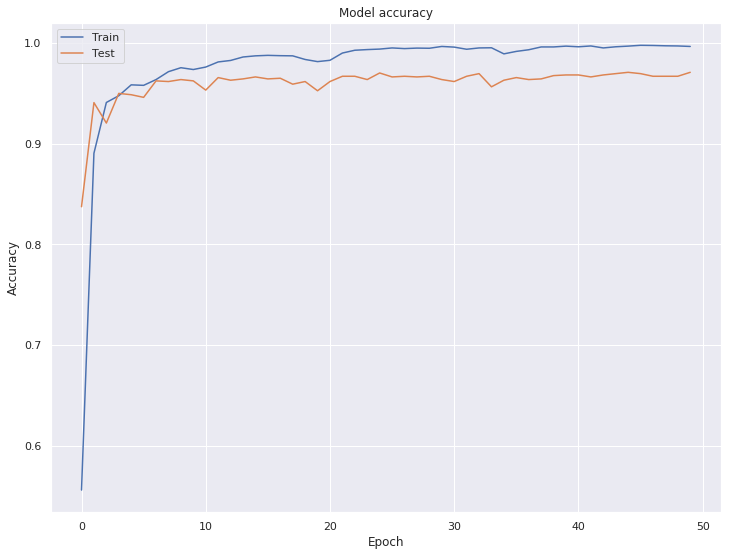

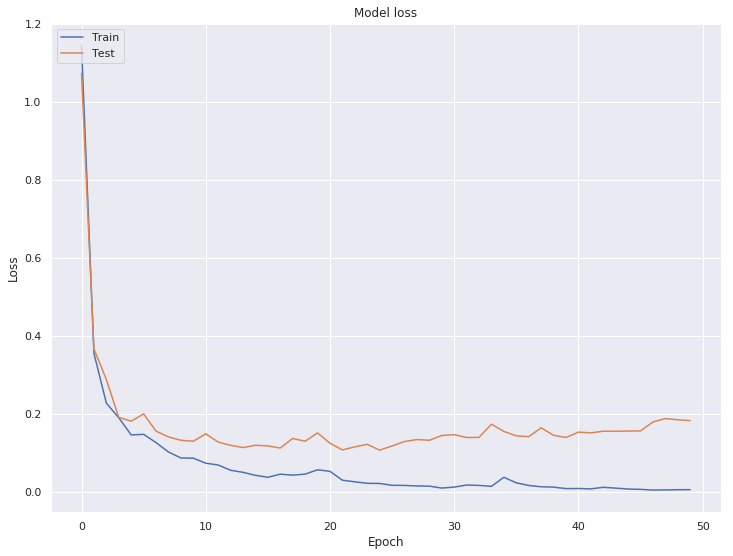

In [71]:
plot.plot(trained.history['acc'])
plot.plot(trained.history['val_acc'])
plot.title('Model accuracy')
plot.ylabel('Accuracy')
plot.xlabel('Epoch')
plot.legend(['Train', 'Test'], loc='upper left')
plot.show()

plot.plot(trained.history['loss'])
plot.plot(trained.history['val_loss'])
plot.title('Model loss')
plot.ylabel('Loss')
plot.xlabel('Epoch')
plot.legend(['Train', 'Test'], loc='upper left')
plot.show()

In [0]:
try:
    del data1
    del val1
    del X_val
    del y_val
    del X_train
    del y_train
    #del model
    import gc
    gc.collect()
except:
    pass

In [0]:
test = pd.read_excel('Data_Test.xlsx')

In [0]:
test['STORY'] = test['STORY'].apply(countries)
test['STORY'] = test['STORY'].apply(countries)

test['STORY'] = test['STORY'].apply(known_contractions)
test['STORY'] = test['STORY'].apply(known_contractions)

test['STORY'] = test['STORY'].apply(smart_words)
test['STORY'] = test['STORY'].apply(smart_words)

test['STORY'] = test['STORY'].apply(replace_symbols)
test['STORY'] = test['STORY'].apply(replace_symbols)

test['STORY'] = test['STORY'].apply(preprocessing_numbers)
test['STORY'] = test['STORY'].apply(preprocessing_numbers)

test['STORY'] = test['STORY'].apply(num_to_text)
test['STORY'] = test['STORY'].apply(num_to_text)

test['STORY'] = test['STORY'].apply(handling_decimal_numbers)
test['STORY'] = test['STORY'].apply(handling_decimal_numbers)

test['STORY'] = test['STORY'].apply(pre_processing)
test['STORY'] = test['STORY'].apply(pre_processing)

test['STORY'] = test['STORY'].apply(own_stop_words)
test['STORY'] = test['STORY'].apply(own_stop_words)

test['STORY'] = test['STORY'].apply(left_right_spaces)
test['STORY'] = test['STORY'].apply(left_right_spaces)

test['STORY'] = test['STORY'].apply(preprocessing_numbers)
test['STORY'] = test['STORY'].apply(preprocessing_numbers)

test['STORY'] = test['STORY'].apply(num_to_text)
test['STORY'] = test['STORY'].apply(num_to_text)

In [0]:
new = test['STORY']
new = new.apply(embeddings)

new = pad_sequences(new, maxlen=SEQUENCE_LENGTH, padding = 'pre', dtype="float32")

In [86]:
new[:1]

array([[[-0.35616  , -0.39059  ,  0.55447  , ..., -0.13571  ,
          0.013178 ,  0.26619  ],
        [-0.11697  ,  0.058529 , -0.050612 , ...,  0.24277  ,
         -0.17975  , -0.18293  ],
        [ 0.16082  ,  0.11008  , -0.28129  , ...,  0.12435  ,
         -0.27433  ,  0.65513  ],
        ...,
        [-0.091755 ,  0.23209  ,  0.12956  , ...,  0.39148  ,
         -0.065411 ,  0.12674  ],
        [ 0.49149  ,  0.19064  ,  0.44208  , ...,  0.22995  ,
          0.10845  ,  0.11183  ],
        [-0.044382 ,  0.17593  ,  0.0022034, ..., -0.30295  ,
          0.01211  ,  0.15438  ]]], dtype=float32)

In [0]:
predictions_array = model.predict(new)

In [0]:
predictions = []
for pred in predictions_array:
    predictions.append(np.argmax(pred))


In [0]:
predictions = np.array(predictions)

In [0]:
submission = pd.DataFrame(columns = ['SECTION'])

In [0]:
submission['SECTION'] = predictions

In [0]:
submission.to_excel('submisson_1.xlsx', index=False)

In [0]:
submission = pd.read_excel('submisson_1.xlsx')
submission